Import Required Libraries

In [22]:
import os
import pandas as pd
import numpy as np
from PIL import Image
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torchvision.models import efficientnet_b0, EfficientNet_B0_Weights
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score

Build Data Frame for training and testing

In [2]:
# Build dataset from folders
def build_dataframe():
    data = []
    for label, folder in enumerate(['ai', 'real']):
        n = 0
        for file in os.listdir(folder):
            if n == 30000:
                break
            if file.lower().endswith(('.jpg', '.jpeg', '.png', '.webp', '.gif')):
                n += 1
                data.append({'file_name': os.path.join(folder, file), 'label': label})
    df = pd.DataFrame(data)
    return train_test_split(df, test_size=0.2, stratify=df['label'], random_state=42)

train_df, val_df = build_dataframe()
test_files = os.listdir('test_data/teamspace/studios/this_studio/final_test_renamed')
test_df = pd.DataFrame({'file_name': [f'test_data/teamspace/studios/this_studio/final_test_renamed/{x}' for x in test_files]})

Data loading and Definings Transforms

In [3]:
# Dataset
class ImageDataset(Dataset):
    def __init__(self, df, transform=None, is_test=False):
        self.df = df.reset_index(drop=True)
        self.transform = transform
        self.is_test = is_test

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        path = self.df.iloc[idx]['file_name']
        try:
            image = Image.open(path).convert('RGB')
        except (OSError, ValueError) as e:
            print(f"⚠️ Skipping corrupted image: {path}")
            # Fallback: Return a black image
            image = Image.new('RGB', (224, 224), (0, 0, 0))
        
        if self.transform:
            image = self.transform(image)
        
        if self.is_test:
            return image, -1
        else:
            label = int(self.df.iloc[idx]['label'])
            return image, label


# Transforms
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

Tunned Hyperparameters

In [4]:
# Hyperparameters from Optuna
BATCH_SIZE = 128
LR = 0.000762
WEIGHT_DECAY = 0.00038036

DataSet loading and Define the model

In [5]:
# DataLoaders (⬅️ Made memory-efficient: num_workers=2 and pin_memory=True)
train_dataset = ImageDataset(train_df, transform=train_transform)
val_dataset = ImageDataset(val_df, transform=test_transform)
test_dataset = ImageDataset(test_df, transform=test_transform, is_test=True)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0, pin_memory=True)

# Load pretrained model from saved weights
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = efficientnet_b0(weights=None)  # ⬅️ No default weights since we are loading our own
num_ftrs = model.classifier[1].in_features
model.classifier[1] = nn.Linear(num_ftrs, 2)

model.load_state_dict(torch.load('best_model_3.pth', map_location=device))  # ⬅️ Load from given path
model = model.to(device)
model.eval()  # Set to eval mode for inference


# Freeze all layers except last few (⬅️ Same)
for param in model.parameters():
    param.requires_grad = False
for param in model.features[-3:].parameters():
    param.requires_grad = True
for param in model.classifier.parameters():
    param.requires_grad = True

model = model.to(device)

C:\Users\Asus\AppData\Local\Temp\ipykernel_15804\230696021.py:17: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model_3.pth', map_loca

Training

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

# Training loop with early stopping (⬅️ Added Early Stopping logic)
best_val_acc = 0
patience = 3
counter = 0

for epoch in range(20):
    print(f"Epch no {epoch}")
    model.train()
    correct = 0
    total = 0
    running_loss = 0.0
    n =0
    for images, labels in train_loader:
        n+=1
        print(f"epoch {epoch } sub ep {n}")
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    train_acc = 100 * correct / total

    # Validation
    model.eval()
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            val_correct += (predicted == labels).sum().item()
            val_total += labels.size(0)

    val_acc = 100 * val_correct / val_total
    torch.save(model.state_dict(), f'best_model_4_epoch {epoch}_train_{train_acc}_val_{val_acc}.pth')
    print(f"Epoch {epoch+1}: Train Acc = {train_acc:.2f}%, Val Acc = {val_acc:.2f}%")
    scheduler.step()

    # Free up unused memory (⬅️ Added)
    torch.cuda.empty_cache()

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), 'best_model_4.pth')
        counter = 0
    else:
        counter += 1
        if counter >= patience:
            print("⛔ Early stopping triggered.")
            break

Save Final prediction on test data in a CSV

In [6]:
# Load best model for inference
model.load_state_dict(torch.load('best_model_4_epoch 8_train_98.37953572233491_val_91.9138195258271.pth'))
model.eval()

C:\Users\Asus\AppData\Local\Temp\ipykernel_15804\993343059.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model_4_epoch 8_train_9

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [ ]:
# Load best model for inference
model.load_state_dict(torch.load('best_model_4.pth'))
model.eval()

# Inference on test data
preds = []
with torch.no_grad():
    for images, _ in test_loader:
        images = images.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        preds.extend(predicted.cpu().numpy())

# Submission
submission = pd.DataFrame({
    'filename': test_df['file_name'].apply(lambda x: os.path.basename(x)),
    'class': preds
})
submission.to_csv('final_submission_4.csv', index=False)
print("✅ final_submission.csv saved successfully!")
print(submission.head())

## Ensemble Learning

In [24]:
import pandas as pd
from collections import Counter

# Load the CSVs
d1 = pd.read_csv("final_submission_4_8.csv")
d2 = pd.read_csv("submission_resnet_50.csv")
d3 = pd.read_csv("final_submission_4_3.csv")

# Merge based on filename
merged = d1.merge(d2, on='filename', suffixes=('_1', '_2')).merge(d3, on='filename')
merged.rename(columns={'class': 'class_3'}, inplace=True)

# Apply majority voting
def vote(row):
    votes = [row['class_1'], row['class_2'], row['class_3']]
    return Counter(votes).most_common(1)[0][0]

merged['class'] = merged.apply(vote, axis=1)

# Create final dataframe
ensemble_df = merged[['filename', 'class']]

# Save to CSV
ensemble_df.to_csv("ensemble_1.csv", index=False)

print("Ensemble saved as ensemble_1.csv ✅")


Ensemble saved as ensemble_1.csv ✅


## Visualization

In [7]:
!pip install torchcam

  Using cached numpy-1.26.4-cp310-cp310-win_amd64.whl.metadata (61 kB)
  Using cached matplotlib-3.10.1-cp310-cp310-win_amd64.whl.metadata (11 kB)
  Using cached contourpy-1.3.1-cp310-cp310-win_amd64.whl.metadata (5.4 kB)
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
  Using cached kiwisolver-1.4.8-cp310-cp310-win_amd64.whl.metadata (6.3 kB)
Using cached matplotlib-3.10.1-cp310-cp310-win_amd64.whl (8.1 MB)
Using cached numpy-1.26.4-cp310-cp310-win_amd64.whl (15.8 MB)
Using cached contourpy-1.3.1-cp310-cp310-win_amd64.whl (218 kB)
Using cached cycler-0.12.1-py3-none-any.whl (8.3 kB)
   ---------------------------------------- 0.0/2.2 MB ? eta -:--:--
   ---------------------------------------- 2.2/2.2 MB 24.9 MB/s eta 0:00:00
Using cached kiwisolver-1.4.8-cp310-cp310-win_amd64.whl (71 kB)
  Attempting uninstall: numpy
    Found existing installation: numpy 2.2.4
    Uninstalling numpy-2.2.4:
      Successfully uninstalled numpy-2.2.4


  You can safely remove it manually.
  You can safely remove it manually.


In [ ]:
!pip install grad-cam -q

In [14]:
pip uninstall numpy opencv-python opencv-python-headless -y -q

Note: you may need to restart the kernel to use updated packages.


You can safely remove it manually.
You can safely remove it manually.


In [15]:
!pip install numpy==1.23.5
!pip install opencv-python==4.7.0.72


   ---------------------------------------- 0.0/14.6 MB ? eta -:--:--
   ---------- ----------------------------- 3.9/14.6 MB 23.5 MB/s eta 0:00:01
   -------------------------- ------------- 9.7/14.6 MB 25.2 MB/s eta 0:00:01
   ---------------------------------------  14.4/14.6 MB 25.9 MB/s eta 0:00:01
   ---------------------------------------- 14.6/14.6 MB 24.9 MB/s eta 0:00:00


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
grad-cam 1.5.4 requires opencv-python, which is not installed.


   ---------------------------------------- 0.0/38.2 MB ? eta -:--:--
   ---- ----------------------------------- 4.5/38.2 MB 30.0 MB/s eta 0:00:02
   ---------- ----------------------------- 10.2/38.2 MB 27.7 MB/s eta 0:00:02
   --------------- ------------------------ 14.4/38.2 MB 25.2 MB/s eta 0:00:01
   --------------------- ------------------ 20.2/38.2 MB 26.0 MB/s eta 0:00:01
   --------------------------- ------------ 26.2/38.2 MB 26.4 MB/s eta 0:00:01
   --------------------------------- ------ 32.0/38.2 MB 26.7 MB/s eta 0:00:01
   ---------------------------------------  38.0/38.2 MB 27.2 MB/s eta 0:00:01
   ---------------------------------------- 38.2/38.2 MB 26.1 MB/s eta 0:00:00


In [16]:
pip install --force-reinstall grad-cam


Note: you may need to restart the kernel to use updated packages.
  Using cached grad_cam-1.5.4-py3-none-any.whl
  Using cached numpy-2.2.4-cp310-cp310-win_amd64.whl.metadata (60 kB)
  Using cached pillow-11.1.0-cp310-cp310-win_amd64.whl.metadata (9.3 kB)
  Using cached torch-2.6.0-cp310-cp310-win_amd64.whl.metadata (28 kB)
  Using cached ttach-0.0.3-py3-none-any.whl.metadata (5.2 kB)
  Using cached tqdm-4.67.1-py3-none-any.whl.metadata (57 kB)
  Using cached opencv_python-4.11.0.86-cp37-abi3-win_amd64.whl.metadata (20 kB)
  Using cached matplotlib-3.10.1-cp310-cp310-win_amd64.whl.metadata (11 kB)
  Using cached scikit_learn-1.6.1-cp310-cp310-win_amd64.whl.metadata (15 kB)
  Using cached filelock-3.18.0-py3-none-any.whl.metadata (2.9 kB)
  Using cached typing_extensions-4.13.1-py3-none-any.whl.metadata (3.0 kB)
  Using cached networkx-3.4.2-py3-none-any.whl.metadata (6.3 kB)
  Using cached jinja2-3.1.6-py3-none-any.whl.metadata (2.9 kB)
  Using cached fsspec-2025.3.2-py3-none-any.whl.m

  You can safely remove it manually.
  You can safely remove it manually.
  You can safely remove it manually.
  You can safely remove it manually.
  You can safely remove it manually.
  You can safely remove it manually.
ERROR: Could not install packages due to an OSError: [WinError 5] Access is denied: 'c:\\users\\asus\\appdata\\local\\programs\\python\\python310\\lib\\site-packages\\matplotlib\\backends\\_backend_agg.cp310-win_amd64.pyd'
Consider using the `--user` option or check the permissions.



      Successfully uninstalled colorama-0.4.6
  Attempting uninstall: tqdm
    Found existing installation: tqdm 4.67.1
    Uninstalling tqdm-4.67.1:
      Successfully uninstalled tqdm-4.67.1
  Attempting uninstall: scipy
    Found existing installation: scipy 1.15.2
    Uninstalling scipy-1.15.2:
      Successfully uninstalled scipy-1.15.2
  Attempting uninstall: python-dateutil
    Found existing installation: python-dateutil 2.9.0.post0
    Uninstalling python-dateutil-2.9.0.post0:
      Successfully uninstalled python-dateutil-2.9.0.post0
  Attempting uninstall: opencv-python
    Found existing installation: opencv-python 4.7.0.72
    Uninstalling opencv-python-4.7.0.72:
      Successfully uninstalled opencv-python-4.7.0.72
  Attempting uninstall: jinja2
    Found existing installation: Jinja2 3.1.6
    Uninstalling Jinja2-3.1.6:
      Successfully uninstalled Jinja2-3.1.6
  Attempting uninstall: contourpy
    Found existing installation: contourpy 1.3.1
    Uninstalling contourpy

In [17]:
import numpy as np
import cv2
from pytorch_grad_cam import GradCAM
print("✅ Everything imported correctly!")


✅ Everything imported correctly!


In [ ]:
import torch
import torchvision.transforms as transforms
import numpy as np
import cv2
from PIL import Image
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
from torchvision.models import efficientnet_b0
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget

# Device setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load model
model = efficientnet_b0(pretrained=True).to(device)
model.eval()

# Target layer for CAM
target_layers = [model.features[-1]]

# Load and preprocess image
img_path = 'real/6.jpg'
img = Image.open(img_path).convert('RGB')
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])
img_tensor = transform(img).unsqueeze(0).to(device)

# Init CAM (no use_cuda arg in newer versions)
cam = GradCAM(model=model, target_layers=target_layers)

# Predict
output = model(img_tensor)
pred_class = output.argmax(dim=1).item()

# Generate CAM
grayscale_cam = cam(input_tensor=img_tensor, targets=[ClassifierOutputTarget(pred_class)])
grayscale_cam = grayscale_cam[0, :]

# Overlay CAM on original image
rgb_img = np.array(img.resize((224, 224))) / 255.0
cam_image = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)

# Save result
cv2.imwrite("cam_result_real.jpg", cv2.cvtColor(cam_image, cv2.COLOR_RGB2BGR))
print("✅ Grad-CAM result saved as 'cam_result.jpg'")


✅ Grad-CAM result saved as 'cam_result.jpg'


c:\Users\Asus\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Asus\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


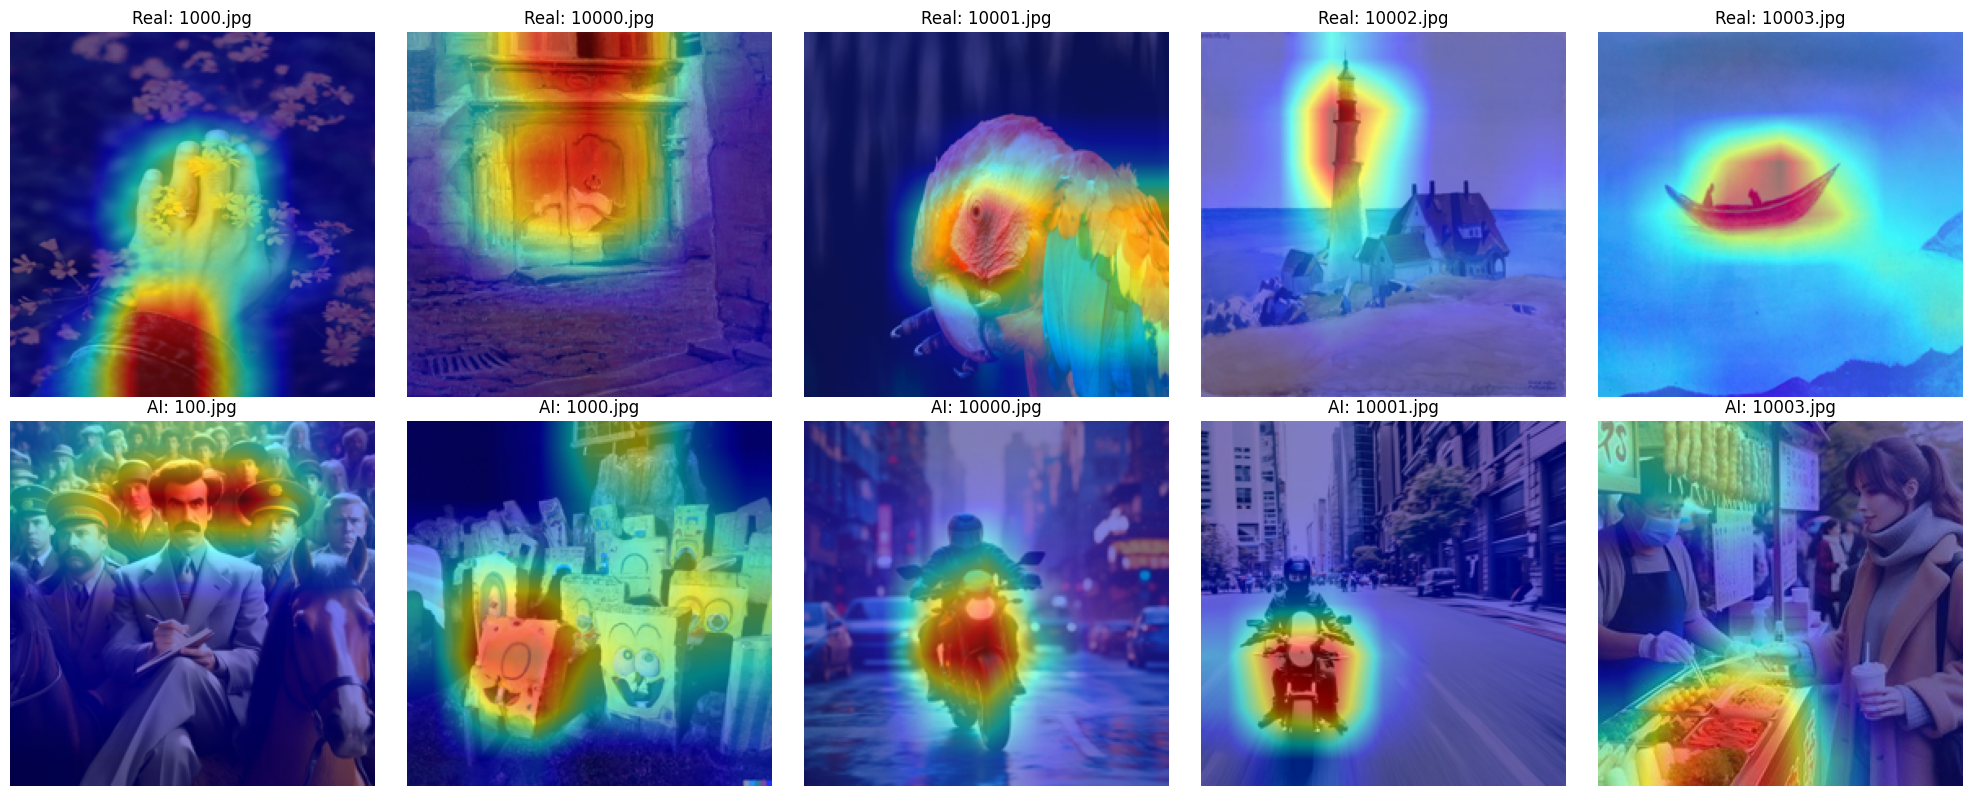

✅ Grid of Grad-CAM results saved as 'gradcam_real_ai_grid.jpg'


In [25]:
import torch
import torchvision.transforms as transforms
import numpy as np
import cv2
import os
from PIL import Image
import matplotlib.pyplot as plt
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
from torchvision.models import efficientnet_b0
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget

# Device setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load model
model = efficientnet_b0(pretrained=True).to(device)
model.eval()
target_layers = [model.features[-1]]

# Grad-CAM object
cam = GradCAM(model=model, target_layers=target_layers)

# Image transform
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

# Helper function to get CAM image
def get_cam_image(img_path):
    img = Image.open(img_path).convert('RGB')
    img_tensor = transform(img).unsqueeze(0).to(device)

    output = model(img_tensor)
    pred_class = output.argmax(dim=1).item()

    grayscale_cam = cam(input_tensor=img_tensor, targets=[ClassifierOutputTarget(pred_class)])[0]
    rgb_img = np.array(img.resize((224, 224))) / 255.0
    cam_image = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)
    return cam_image

# Load first 5 images from each folder
real_imgs = sorted(os.listdir("real"))[:5]
ai_imgs = sorted(os.listdir("ai"))[:5]

# Plotting
fig, axs = plt.subplots(2, 5, figsize=(20, 8))
for i, fname in enumerate(real_imgs):
    cam_img = get_cam_image(os.path.join("real", fname))
    axs[0, i].imshow(cam_img)
    axs[0, i].set_title(f"Real: {fname}")
    axs[0, i].axis('off')

for i, fname in enumerate(ai_imgs):
    cam_img = get_cam_image(os.path.join("ai", fname))
    axs[1, i].imshow(cam_img)
    axs[1, i].set_title(f"AI: {fname}")
    axs[1, i].axis('off')

plt.tight_layout()
plt.savefig("gradcam_real_ai_grid.jpg")
plt.show()
print("✅ Grid of Grad-CAM results saved as 'gradcam_real_ai_grid.jpg'")
